In [2]:
""" 
required if not installed:

!pip install -U spacy
import sys
!{sys.executable} -m spacy download en_core_web_lg

"""

# Packages for Data Manipulation
import numpy as np
import pandas as pd
import os
from collections import Counter
import spacy

# for NLP
import re
import unicodedata
from bs4 import BeautifulSoup

# Packages for Graphics
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Packages for ML
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import fbeta_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# to see all the cells and data in the dataframes
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_colwidth', 300) 

# to hide warnings about train/test size for train_test_split
import warnings
warnings.filterwarnings('ignore')

# Import normalized dataset

In [3]:
df = pd.read_csv('politifact_binarized_light_full_normalization.csv')
df.head()

,statement,veracity,light_normalization,full_normalization
0,"Sen. Kamala Harris is ""supporting the animals of MS-13.""",0,"sen. kamala harris is ""supporting the animals of ms-13.""",sen kamala harris support animal
1,"Says Ronald Reagan said immigrants ""brought with them courage and the values of family, work, and freedom. Let us pledge to each other that we can make America great again.""",1,"says ronald reagan said immigrants ""brought with them courage and the values of family, work, and freedom. let us pledge to each other that we can make america great again.""",ronald reagan immigrant bring courage value family work freedom let pledge america great
2,"Says Democratic Senators ""demand Supreme Court nominee not be unduly influenced by U.S. Constitution.""",0,"says democratic senators ""demand supreme court nominee not be unduly influenced by u.s. constitution.""",democratic senator demand supreme court nominee unduly influence constitution
3,"""Tim Kaine doesn’t want a border at all. He wants to get rid of Immigration and Customs Enforcement and basically the border patrol as well.""",0,"""tim kaine doesnt want a border at all. he wants to get rid of immigration and customs enforcement and basically the border patrol as well.""",tim kaine want border want rid immigration custom enforcement basically border patrol
4,"""George H.W. Bush has died at 94.""",0,"""george h.w. bush has died at 94.""",george bush die


# Start the Normalization Process (skip if dataset has already been normalized)

In [3]:
# csv to df
path = os.path.abspath('politifact_clean_binarized.csv')
df = pd.read_csv(path)

# specify rows of importance
df = df[["veracity", "statement"]]

# See sample of data
df.head(5)

,veracity,statement
0,0,"Sen. Kamala Harris is ""supporting the animals of MS-13."""
1,1,"Says Ronald Reagan said immigrants ""brought with them courage and the values of family, work, and freedom. Let us pledge to each other that we can make America great again."""
2,0,"Says Democratic Senators ""demand Supreme Court nominee not be unduly influenced by U.S. Constitution."""
3,0,"""Tim Kaine doesn’t want a border at all. He wants to get rid of Immigration and Customs Enforcement and basically the border patrol as well."""
4,0,"""George H.W. Bush has died at 94."""


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11188 entries, 0 to 11187
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   veracity   11188 non-null  int64 
 1   statement  11188 non-null  object
dtypes: int64(1), object(1)
memory usage: 174.9+ KB


In [9]:
# this cell is most useful for imbalanced data
# ratio of true to false in the data set (i.e., our "chance" baseline)

print("true statements: ", round(len(df.veracity[df.veracity == True]),2))
print("false statements: ", round(len(df.veracity[df.veracity == False]),2))

tru_count = len(df.veracity[df.veracity == True])
fal_count = len(df.veracity[df.veracity == False])

print("chance of truth baseline: ", round(tru_count/(tru_count + fal_count),2)) # len(df) as denominator also works
print("chance of false baseline: ", round(fal_count/(tru_count + fal_count),2))

true statements:  4853
false statements:  6335
chance of truth baseline:  0.43
chance of false baseline:  0.57


# Creating normalized text

In [13]:
nlp = spacy.load('en_core_web_lg')

def strip_html_tags(text):
            soup = BeautifulSoup(text, "html.parser")
            [s.extract() for s in soup(["iframe", "script"])]
            stripped_text = soup.get_text()
            stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
            return stripped_text
        
def remove_accented_characters(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

In [14]:
# lemmatization function
def normalize(text, 
              remove_html = False, 
              lowercase = False,
              lemmatize = False,
              remove_extra_newlines = False,
              remove_stopwords = False,
              remove_non_alphabetic = False,
              remove_accented_char = False,
              ):
        
    # remove html
    if remove_html:
        text = strip_html_tags(text)

    # lowercase all text
    if lowercase:
        text = text.lower()
        
    # lemmatize
    if lemmatize:        
        text = nlp(text)
        text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
        
    # remove extra new lines    
    if remove_extra_newlines:
        text = re.sub(r'[\r|\n|\r\n]+', ' ', text)
    
    # remove stopwords
    if remove_stopwords:
        stopwords = spacy.lang.en.stop_words.STOP_WORDS
        text = nlp(text)
        text = ' '.join([token.text for token in text if token.text not in stopwords])
    
    # remove non-alphabetic characters
    if remove_non_alphabetic:
        text = nlp(text)
        text = ' '.join([token.text for token in text if token.text.isalpha()])
        
    # remove accented characters
    if remove_accented_char:
        text = remove_accented_characters(text)

    return text

# Light Normalization

In [15]:
# sample of light normalizer
string = "@ ! i DON'TTT, won't, a féél    can't not USING the  NLP 27x maaaah?"

normalize(string, 
          remove_html = True, 
          lowercase = True,
          remove_extra_newlines = True,
          remove_accented_char = True)

"@ ! i don'ttt, won't, a feel    can't not using the  nlp 27x maaaah?"

In [16]:
df["light_normalization"] = df.statement.apply(lambda x : normalize(x, 
                                                                  remove_html = True, 
                                                                  lowercase = True,
                                                                  remove_extra_newlines = True,
                                                                  remove_accented_char = True))

# Full Normalization

In [17]:
# sample of full normalizer
normalize(string, 
          remove_html = True, 
          lowercase = True,
          remove_extra_newlines = True,
          remove_accented_char = True,
          lemmatize = True, # note that lemmatize does not work properly if text is not lowercased first
          remove_stopwords = True,
          remove_non_alphabetic = True) 

# non_alphabetic will remove not only non-alphabetic characters, but also blank spaces

'I wo feel use nlp maaaah'

In [18]:
df["full_normalization"] = df.statement.apply(lambda x : normalize(x, 
                                                                    remove_html = True, 
                                                                    lowercase = True,
                                                                    remove_extra_newlines = True,
                                                                    remove_accented_char = True,
                                                                    lemmatize = True,
                                                                    remove_stopwords = True,
                                                                    remove_non_alphabetic = True))

In [19]:
df.head(1)

,veracity,statement,light_normalization,full_normalization
0,0,"Sen. Kamala Harris is ""supporting the animals of MS-13.""","sen. kamala harris is ""supporting the animals of ms-13.""",sen kamala harris support animal


# Bag of Words (BoW) Model: Vectorizing Text

This is the process of turning text into a series of numbers (vectors) for machine learning models

each word is mapped to its frequency as follows:

step 1 - original sentence ->       NLP is amazing; truly NLP is amazing. 

step 2 - unique words arranged alphabetically -> amazing, is, NLP, truly

step 3 - mapped to frequency ->     (2, 2, 2, 1)

# Cell below this is a class I created for Binary Classification problems

# Example Use:

### models = Binary_Classification(x, y, standardize = True, scoring = "roc_auc")
takes in x and y, standarizes all continuous columns, performs train_test_split (test_size = 0.3), and performs GridSearchCV on train (n_folds = 5); the metric to evaluate models against will be roc_auc in this case

### models.compare()
will compare several models against one another and compute best parameters for each model

models compared: logistic regression, k-nearest neighbor, gaussian naive bayes, multi nomial naive bayes, random forest, and if desired xtreme gradient boosting (usually takes more than 5 minutes to run so it has been commented out)

### models.test_scores("ran_for", verbose_results = False)
will compute f1, accuracy, and roc_auc score for training and test data using model given (in this case using random forest); verbose_results set to True will generate more details of the results

### models.permutation_importance("ran_for")
will determine which features are most important to the model. "The permutation feature importance is defined to be the decrease in a model score when a single feature value is randomly shuffled." (https://scikit-learn.org/dev/modules/permutation_importance.html) Permutation importances is computed on the held-out validation set, because "a held-out set makes it possible to highlight which features contribute the most to the generalization power of the inspected model. Features that are important on the training set but not on the held-out set might cause the model to overfit." (same source)

see also: https://www.kaggle.com/dansbecker/permutation-importance

In [9]:
class Binary_Classification:
    def __init__(self, 
                 x = None, 
                 y = None, 
                 scoring = None, 
                 test_size = 0.3, 
                 n_folds = 3, 
                 standardize = False,
                 nlp = False,
                 vectorizer = None): 
        
        self.x = x # features as df
        self.y = y # target as df
        self.scoring = scoring # example: "accuracy", "f1", "roc_auc"
        self.test_size = test_size # set to .3 by default
        self.n_folds = n_folds # set to 5 by default
        self.standardize = standardize
        self.x_train, self.x_test, self.y_train, self.y_test = \
        train_test_split(self.x, 
                         self.y, 
                         test_size = self.test_size, 
                         random_state = 0)
        if nlp:
            self.x_train = vectorizer.fit_transform(self.x_train)
            self.x_test = vectorizer.transform(self.x_test)
    
    """ 
    .examine_model attribute has two functions within it:
    (1) model_and_grid => using a model's name, it returns the model with cvgrid
    (2) best_model => using model_and_grid, finds best hyperparameters for model
    """
    
    def examine_model(self, model_name):
        
        def model_and_grid(model_name):
            if model_name == "log_reg":
                model = LogisticRegression()
                grid = {'C' : [0.001, 0.1, 1, 10, 100]}
                return model, grid

            elif model_name == "knn":
                model = KNeighborsClassifier()
                grid = {"n_neighbors" : [3,6,9,12]}
                return model, grid
            
            elif model_name == "gnb":
                model = GaussianNB()
                grid = {"var_smoothing" : [1e-01, 1e-05, 1e-09, 1e-15]}
                return model, grid
            
            elif model_name == "mnb":
                model = MultinomialNB()
                grid = {"alpha" : [.1, 1, 5, 10, 50]}
                return model, grid
            
            elif model_name == "ran_for":
                model = RandomForestClassifier(random_state=0)
                grid = {'n_estimators' : [1, 30], 
                        'max_features' : ['auto', 'log2'],  
                        'max_depth' : [ 3, 5, 7, 10, 12, 15], 
                        'criterion' : ['gini', 'entropy']}
                return model, grid

            elif model_name == "xgb":
                model = XGBClassifier()
                grid = { 
                          "max_depth"         : [2, 4, 8, 16],
                          "alpha"             : [10, 20, 30],
                          "lambda"            : [10, 20, 30],
        #                  "min_child_weight" : [  1,  5],
        #                  "colsample_bytree" : [ .3, .7],
        #                  "learning_rate"    : [.10, .30],
        #                  "gamma"            : [  0, .5, 5],
        #                  "eta"              : [0.05, 0.20]
                }  
                return model, grid
        
        def best_model(model, grid):
            gs = GridSearchCV(model, param_grid=grid, cv=self.n_folds, scoring=self.scoring)
            gs.fit(self.x_train, self.y_train.iloc[:,0])
            print("CV " + self.scoring.upper() + " SCORE:", round(gs.best_score_, 2))
            print("CV PARAMS: ", gs.best_params_)
            #print("BEST MODEL: ", gs.best_estimator_)
            best_model = gs.best_estimator_
            return best_model

        model, grid = model_and_grid(model_name)
        best_mod = best_model(model, grid)
        return best_mod

    """ 
    .compare attribute uses examine_model to compare all models
    """
    
    def compare(self):
        z = 0
        mods = ["log_reg", 
                #"knn", 
                #"gnb", 
                "mnb", 
                "ran_for",
                #"xgb"
               ]
        for name in mods:
            print("*** " + mods[z] + " ***")
            self.examine_model(name)
            print("")
            z += 1
    
    """ 
    .test_scores attribute uses examine_model to report various metrics on training & test data
    """
    
    def test_scores(self, 
                    model_name = None, 
                    verbose_results = False, 
                    all_metrics = True): 
        model = self.examine_model(model_name)
        y_pred_train = model.predict(self.x_train)
        y_pred_test = model.predict(self.x_test)
        y_prob_train = model.predict_proba(self.x_train)[:,1]
        y_prob_test = model.predict_proba(self.x_test)[:,1]
        
        print()
        """ Accuracy """
        ## number of correct predictions made / total number of predictions made
        ### accuracy is not a good metric for imbalanced data
        if self.scoring == "accuracy" or all_metrics:
            accuracy_training = model.score(self.x_train, self.y_train)
            tru_count_train = Counter(self.y_train.iloc[:,0])[True]
            fal_count_train = Counter(self.y_train.iloc[:,0])[False]

            # test baseline
#             print("chance of true in training (baseline): ", 
#                   round(tru_count_train/(tru_count_train + fal_count_train),2))
#             print("chance of false in training (baseline): ", 
#                   round(fal_count_train/(tru_count_train + fal_count_train),2))
            
#             print("Accuracy on training data: {:0.2f}".format(accuracy_training))
#             print()

            accuracy_test = model.score(self.x_test, self.y_test)
            tru_count_test = Counter(self.y_test.iloc[:,0])[True]
            fal_count_test = Counter(self.y_test.iloc[:,0])[False]

            # test baseline
#                 print("chance of true in test (baseline): ", 
#                       round(tru_count_test/(tru_count_test + fal_count_test),2))
#                 print("chance of false in test (baseline): ", 
#                       round(fal_count_test/(tru_count_test + fal_count_test),2))

            print("Accuracy on test data: {:0.2f}".format(accuracy_test))
            print()

        """ ROC AUC """
        ## How well model distinguishs between classes
        ### Higher the AUC, better the model is at predicting 0 as 0 and 1 as 1
        #### https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5
        if self.scoring == "roc_auc" or all_metrics:
            roc_auc_score_training = roc_auc_score(self.y_train.iloc[:,0], y_prob_train)
#             print("ROC AUC on training data:{:0.2f}".format(roc_auc_score_training))

            roc_auc_score_test = roc_auc_score(self.y_test.iloc[:,0], y_prob_test)
            print("ROC AUC on test data: {:0.2f}\n".format(roc_auc_score_test))
                
        """ F1 (f-one) Score """
        ## F1 Score = 2*((precision*recall)/(precision+recall))
        if self.scoring == "f1" or all_metrics:
            f1_train = metrics.f1_score(self.y_train.iloc[:,0], y_pred_train)
#             print("F1 on training data:{:0.2f}".format(f1_train))

            f1_test = metrics.f1_score(self.y_test.iloc[:,0], y_pred_test)
            print("F1 on test data: {:0.2f}".format(f1_test))
            print()

        """ Classification Report """
        ## Precision = TP / TP + FP
        ## Recall = TP/ TP + FN
        class_repo = classification_report(self.y_test,y_pred_test)
        print("Classification Report on test data:\n", class_repo)
            
        """ Confusion matrix """
        def print_confusion_matrix(confusion_matrix, 
                           class_names,
                           #figsize = (2,2), fontsize=20
                          ):
    
            """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
            2 benefits: (1) mieruka (i.e., visual control) and 
            (2) colors change depending on values (larger values generate darker colors)
            
            if you're wondering what mieruka is: 
            https://harishsnotebook.wordpress.com/2016/05/05/visibilization-crime-fighting-magic-and-mieruka/

            Arguments
            ---------
            confusion_matrix: numpy.ndarray
                The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
                Similarly constructed ndarrays can also be used.
            class_names: list
                An ordered list of class names, in the order they index the given confusion matrix.
            figsize: tuple
                A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
                the second determining the vertical size. Defaults to (10,7).
            fontsize: int
                Font size for axes labels. Defaults to 14.

            Returns
            -------
            matplotlib.figure.Figure
                The resulting confusion matrix figure
            """

            df_cm = pd.DataFrame(
                confusion_matrix, 
                index=class_names, 
                columns=class_names, 
            )

            fig = plt.figure(#figsize=figsize
            )

            try:
                heatmap = sns.heatmap(df_cm, 
                                      annot=True, 
                                      fmt="d", 
                                      cbar=False, 
                                      cmap="Spectral")
            except ValueError:
                raise ValueError("Confusion matrix values must be integers.")

                heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), 
                                             rotation=0, 
                                             ha='right', 
                                             #fontsize=fontsize
                                            )

                heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), 
                                             rotation=45, 
                                             ha='right', 
                                             #fontsize=fontsize
                                            )
            # for some reason, these two need to be indented and labeled this way, but it prints correctly
            plt.title('Confusion Matrix (Holdout Data)')
            plt.ylabel('Correct label')
            plt.xlabel('Predicted label')
            
        c_matrix = confusion_matrix(self.y_train, y_pred_train)
        print_confusion_matrix(c_matrix, [False, True])
        
        plt.title('Confusion Matrix (Training Data)')
        plt.ylabel('Correct label')
        plt.xlabel('Predicted label')
            
        c_matrix = confusion_matrix(self.y_test, y_pred_test)
        print_confusion_matrix(c_matrix, [False, True])
        
        if verbose_results:
            #Plot ROC curve
            fpr, tpr, thresholds = roc_curve(self.y_test, y_prob_test)
            plt.plot([0, 1], [0, 1], 'k--')
            plt.plot(fpr, tpr)
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('ROC Curve')
            plt.show()
            print("")    
                
            # Threshold Plot
            precision, recall, thresholds = precision_recall_curve(self.y_test, y_prob_test)
            f1 = []
            acc = []
            roc = []
            avg_pr = []

            def adjust_pred_prob(y_prob_test, new_threshold):
                return [1 if prob >= new_threshold else 0 for prob in y_prob_test]

            for t in thresholds:
                adjusted_y_pred = adjust_pred_prob(y_prob_test, t)
                add_f1 = metrics.f1_score(self.y_test, adjusted_y_pred)
                f1.append(add_f1)
                
            for t in thresholds:
                adjusted_y_pred = adjust_pred_prob(y_prob_test, t)
                add_acc = accuracy_score(self.y_test, adjusted_y_pred)
                acc.append(add_acc)
                
            for t in thresholds:
                adjusted_y_pred = adjust_pred_prob(y_prob_test, t)
                add_avg_pr = average_precision_score(self.y_test, adjusted_y_pred)
                avg_pr.append(add_avg_pr)
                
#             ## Retrieve probability of being 1(in second column of probs_y)
#             pr_auc = metrics.auc(recall, precision)

            plt.title("Precision-Recall-Accuracy vs Threshold")
            plt.plot(thresholds, precision[: -1], "b-", label="Precision")
            plt.plot(thresholds, recall[: -1], "r-", label="Recall")
            #plt.plot(thresholds, avg_pr, "k-", label="Average Precision Recall")
            #plt.plot(thresholds, f1, "k-", label="F1_Score")
            plt.plot(thresholds, acc, "g-", label="Accuracy")
            
            max_acc_x = thresholds[np.argmax(acc)]
            plt.axvline(x=max_acc_x, ymin=0.00, ymax=max(acc), color='g', linestyle='-')
            #plt.axhline(y=max(acc), color='g', linestyle='--')
            #plt.text(max_acc_x, max(acc), ("Max Accuracy " + str(round(max_acc_x,2))), rotation=90)
            
            #max_f1_x = thresholds[np.argmax(f1)]
            #plt.axvline(x=max_f1_x, color='k', linestyle='--')
            #plt.axhline(y=max(f1), color='k', linestyle='--')
            #plt.text(max_f1_x, max(f1), ("Max F1 Score " + str(round(max_f1_x,2))), rotation=90)
                        
            plt.ylabel("Score")
            plt.xlabel("Threshold")
            
            #plt.text(intersect_x, intersect_y, 'PR Intersect', rotation=90)
            plt.legend(loc="lower left")
            plt.ylim([0,1])
            plt.show()
            print("Maximum Accuracy: " + str(round(max(acc),2)) + " @ Threshold: " + str(round(max_acc_x,2)))
            #print("Maximum F1 Score: " + str(round(max(f1),2)) + " @ Threshold: " + str(round(max_f1_x,2)))
            
            """ 
            Varying Fscore's beta vs Varying Thresholds
            
            The beta parameter determines the weight of recall in the combined score. 
            beta < 1 lends more weight to precision, while 
            beta > 1 favors recall 
            (beta -> 0 considers only precision, beta -> inf only recall).
            """

            f025 = []
            f050 = []
            f075 = []
            f100 = []
            f125 = []
            f150 = []
            f200 = []

            def fbeta_testing(beta, fxxx):
                for t in thresholds:
                    adjusted_y_pred = adjust_pred_prob(y_prob_test, t)
                    add_fbeta = metrics.fbeta_score(self.y_test, adjusted_y_pred, beta)
                    fxxx.append(add_fbeta)

            betas = [0.25, 0.50, 0.75, 1.00, 1.25, 1.50, 2.00]
            flist = [f025, f050, f075, f100, f125, f150, f200]

            z = 0
            for beta in betas:
                fbeta_testing(beta, flist[z])
                z += 1

            plt.title("F_Beta_Score vs Threshold: Varying Betas")
            #plt.plot(thresholds, f025, "r-", label="F0.25")
            plt.plot(thresholds, f050, "m-", label="F0.50")
            #plt.plot(thresholds, f075, "g-", label="F0.75")
            plt.plot(thresholds, f100, "c-", label="F1.00")
            #plt.plot(thresholds, f125, "b-", label="F1.25")
            #plt.plot(thresholds, f150, "k-", label="F1.50")
            plt.plot(thresholds, f200, "y-", label="F2.00")
            #plt.axvline(.425, color='k', linestyle='--')
            #plt.axvline(.45, color='k', linestyle='-')
            
            max_f050_x = thresholds[np.argmax(f050)]
            plt.axvline(x=max_f050_x, ymin=0.00, ymax=max(f050), color='m', linestyle='-')
            max_f100_x = thresholds[np.argmax(f100)]
            plt.axvline(x=max_f100_x,ymin=0.00, ymax=max(f100), color='c', linestyle='-')
            max_f200_x = thresholds[np.argmax(f200)]
            plt.axvline(x=max_f200_x, ymin=0.00, ymax=max(f200), color='y', linestyle='-')
            
            plt.ylabel("F_Beta_Score")
            plt.xlabel("Threshold")
            plt.legend(loc="lower left")
            plt.ylim([0,1])
            plt.show()
            
            print("Maximum F0.5 Score: " + str(round(max(f050),2)) + " @ Threshold: " + str(round(max_f050_x,2)))
            print("Maximum F1   Score: " + str(round(max(f100),2)) + " @ Threshold: " + str(round(max_f100_x,2)))
            print("Maximum F2.0 Score: " + str(round(max(f200),2)) + " @ Threshold: " + str(round(max_f200_x,2)))

            """ Threshold = 0.5, varying fscore's beta """

            betas = [0.25,0.50,0.75,1.00,1.25,1.50,2.00]
            fbetas = []

            for beta in betas:
                score = fbeta_score(self.y_test, y_pred_test, beta=beta)
                fbetas.append(score)
        
    def feature_importance(self, model_name): 
        model = self.examine_model(model_name)
        fitted = model.fit(self.x_train, self.y_train.iloc[:,0])
        
        importances = fitted.feature_importances_
        indices = np.argsort(importances)
        features = self.x_train.columns
        plt.title('Feature Importances')
        plt.barh(range(len(indices)), importances[indices], color='grey', align='center')
        plt.yticks(range(len(indices)), [features[i] for i in indices])
        plt.xlabel('Relative Importance')
        plt.ylabel('Features')
        plt.show()
    
    """ 
    .permutation_importance attribute uses examine_model to report features in order of importance
    """
    def permutation_importance(self, model_name): 
        # https://www.kaggle.com/dansbecker/permutation-importance
        model = self.examine_model(model_name)
        fitted = model.fit(self.x_train, self.y_train.iloc[:,0])
        
        perm = PermutationImportance(fitted, random_state=0).fit(self.x_test, self.y_test.iloc[:,0])
        return eli5.show_weights(perm, feature_names = self.x_test.columns.tolist())
    
    def shap_summary_plot(self, model_name): 
        """Calculating SHAP values can be slow"""
        # https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values
        
        model = self.examine_model(model_name)
        fitted = model.fit(self.x_train, self.y_train.iloc[:,0])
        
        if model_name == "ran_for":
            explainer = shap.TreeExplainer(fitted)
            shap_values = explainer.shap_values(self.x_test)
            # we index in ([1]) to get the SHAP values for the prediction of "True"
            return shap.summary_plot(shap_values[1], self.x_test)
        
        else:     
            """ KernelExplainer cannot handle boolean values, they must be converted to int """
            x_train_summary = shap.kmeans(self.x_train, 3)
            explainer = shap.KernelExplainer(fitted.predict, x_train_summary)
            shap_values = explainer.shap_values(self.x_test)
            return shap.summary_plot(shap_values, self.x_test)
    
    def coefficients(self, model_name):
        model = self.examine_model(model_name)
        try:
            # Coefficients
            coefs = pd.Series(model.coef_[0], index = self.x.columns)
            coefs = coefs.sort_values()
            coefs.plot(kind="bar",title=(model_name.capitalize() + " Coefficients"))
            plt.show()
        except: 
            print()

In [36]:
# For Aesthetics
font = {'size' : 20}
mpl.rc('font', **font)
mpl.rcParams['figure.figsize'] = (6.0, 4.0) ### (→ , ↑) ###

# Light Normalization * Bow Model * 3 Classifiers

In [37]:
models = Binary_Classification(x = df.light_normalization, 
                               y = df[["veracity"]], 
                               scoring = "roc_auc", 
                               test_size = 0.3, 
                               n_folds = 3, 
                               standardize = False,
                               nlp = True,
                               vectorizer = CountVectorizer(lowercase = False))
                     
%time models.compare()

*** log_reg ***
CV ROC_AUC SCORE: 0.67
CV PARAMS:  {'C': 0.1}

*** mnb ***
CV ROC_AUC SCORE: 0.66
CV PARAMS:  {'alpha': 5}

*** ran_for ***
CV ROC_AUC SCORE: 0.64
CV PARAMS:  {'criterion': 'gini', 'max_depth': 15, 'max_features': 'auto', 'n_estimators': 30}

Wall time: 19.9 s


CV ROC_AUC SCORE: 0.67
CV PARAMS:  {'C': 0.1}

ROC AUC on test data: 0.69

Classification Report on test data:
               precision    recall  f1-score   support

           0       0.66      0.78      0.72      1898
           1       0.63      0.49      0.55      1459

    accuracy                           0.65      3357
   macro avg       0.64      0.63      0.63      3357
weighted avg       0.65      0.65      0.64      3357



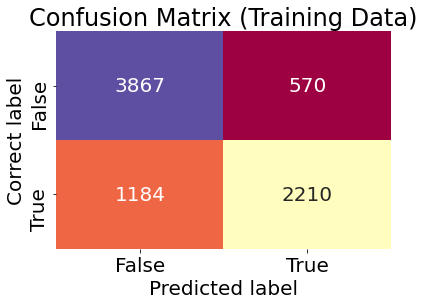

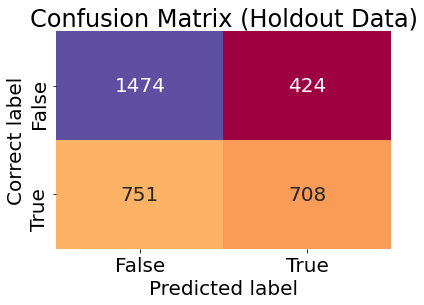

In [38]:
models.test_scores(model_name = "log_reg", 
                   verbose_results = False,
                   all_metrics = False)

# Logistic Regression precision and recall scores are wildly different for Truth and Deception

CV ROC_AUC SCORE: 0.66
CV PARAMS:  {'alpha': 5}

ROC AUC on test data: 0.68

Classification Report on test data:
               precision    recall  f1-score   support

           0       0.66      0.79      0.72      1898
           1       0.63      0.47      0.54      1459

    accuracy                           0.65      3357
   macro avg       0.64      0.63      0.63      3357
weighted avg       0.65      0.65      0.64      3357



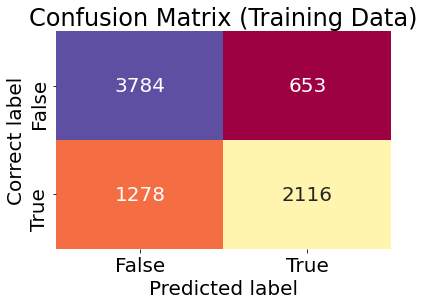

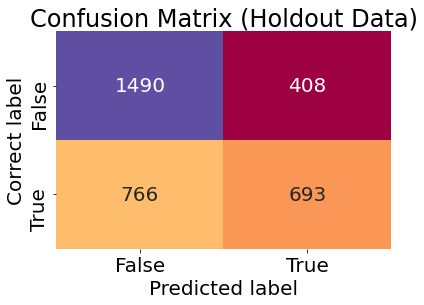

In [39]:
models.test_scores(model_name = "mnb", 
                   verbose_results = False, 
                   all_metrics = False)

# Multinomial Naive Bayes's results are much more stable for precision and recall

# Full Normalization * Bow Model * 3 Classifiers

In [40]:
models = Binary_Classification(x = df.full_normalization, 
                               y = df[["veracity"]], 
                               scoring = "roc_auc", 
                               test_size = 0.3, 
                               n_folds = 3, 
                               standardize = False,
                               nlp = True,
                               vectorizer = CountVectorizer(lowercase = False))
                     
models.compare()

*** log_reg ***
CV ROC_AUC SCORE: 0.66
CV PARAMS:  {'C': 0.1}

*** mnb ***
CV ROC_AUC SCORE: 0.65
CV PARAMS:  {'alpha': 5}

*** ran_for ***
CV ROC_AUC SCORE: 0.64
CV PARAMS:  {'criterion': 'gini', 'max_depth': 15, 'max_features': 'auto', 'n_estimators': 30}



CV ROC_AUC SCORE: 0.66
CV PARAMS:  {'C': 0.1}

ROC AUC on test data: 0.67

Classification Report on test data:
               precision    recall  f1-score   support

           0       0.65      0.79      0.71      1898
           1       0.62      0.45      0.53      1459

    accuracy                           0.64      3357
   macro avg       0.64      0.62      0.62      3357
weighted avg       0.64      0.64      0.63      3357



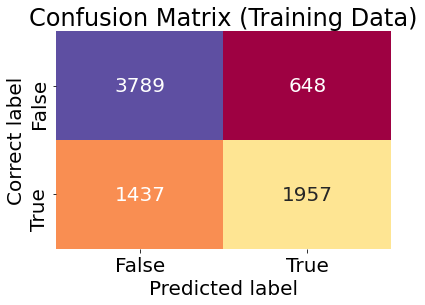

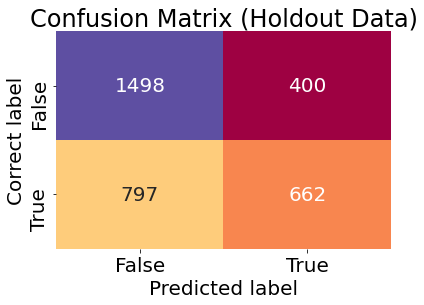

In [41]:
models.test_scores(model_name = "log_reg", 
                   verbose_results = False, 
                   all_metrics = False)

# Again, Logistic Regression's precision and recall scores are wildly different for Truth and Deception

CV ROC_AUC SCORE: 0.65
CV PARAMS:  {'alpha': 5}

ROC AUC on test data: 0.68

Classification Report on test data:
               precision    recall  f1-score   support

           0       0.65      0.78      0.71      1898
           1       0.62      0.47      0.53      1459

    accuracy                           0.64      3357
   macro avg       0.64      0.62      0.62      3357
weighted avg       0.64      0.64      0.63      3357



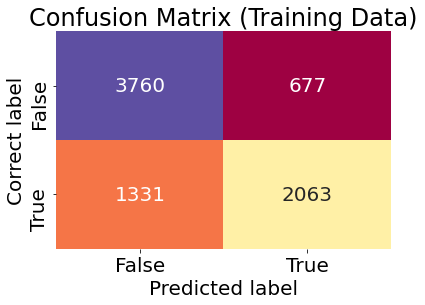

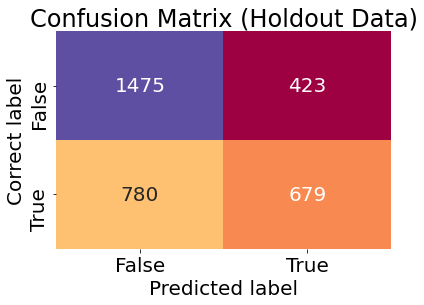

In [42]:
models.test_scores(model_name = "mnb", 
                   verbose_results = False, 
                   all_metrics = False)

# Again, Multinomial Naive Bayes delivers stable precision and recall scores meaning MNB models are more trust-worthy than logistic regression and they are faster than logistic regression

# BoW Model Summary
## None of the models substantially outperform any other model; While full normalization tends to do worse on predicting the training data, it does marginally better on predicting the test data

### BoW's weakness is that words lose context as they are analyzed independently and w/o order

# n-gram model
### n-gram models attempt to make up for Bow's independent treatment of words by giving them context (i.e., dependence)

an n = 2 model example:

step 1 - original sentence   : NLP is amazing; truly NLP is amazing. 

step 2 - n = 2 n-grammed     : NLP is, is amazing, amazing truly, truly NLP, NLP is (repeated), is amazing (repeated)

step 3 - mapped to frequency : (2, 2, 1, 1)

#### a bag of words model is simply n = 1

in general, n >= 4 is not useful as
n-grams of size 4+ are exceedingly rare

source: https://www.datacamp.com/courses/feature-engineering-for-nlp-in-python

# Light Normalization * N-gram Models (1-2 & 1-3) * 3 Classifiers

In [43]:
models = Binary_Classification(x = df.light_normalization, 
                               y = df[["veracity"]], 
                               scoring = "roc_auc", 
                               test_size = 0.3, 
                               n_folds = 3, 
                               standardize = False,
                               nlp = True,
                               vectorizer = CountVectorizer(lowercase = False, ngram_range = (1,2)))
                     
models.compare()

*** log_reg ***
CV ROC_AUC SCORE: 0.69
CV PARAMS:  {'C': 0.1}

*** mnb ***
CV ROC_AUC SCORE: 0.68
CV PARAMS:  {'alpha': 1}

*** ran_for ***
CV ROC_AUC SCORE: 0.65
CV PARAMS:  {'criterion': 'gini', 'max_depth': 15, 'max_features': 'auto', 'n_estimators': 30}



CV ROC_AUC SCORE: 0.69
CV PARAMS:  {'C': 0.1}

ROC AUC on test data: 0.70

Classification Report on test data:
               precision    recall  f1-score   support

           0       0.66      0.77      0.71      1898
           1       0.62      0.49      0.55      1459

    accuracy                           0.65      3357
   macro avg       0.64      0.63      0.63      3357
weighted avg       0.65      0.65      0.64      3357



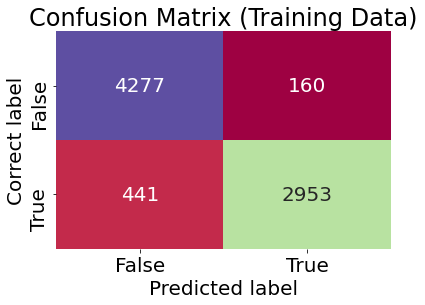

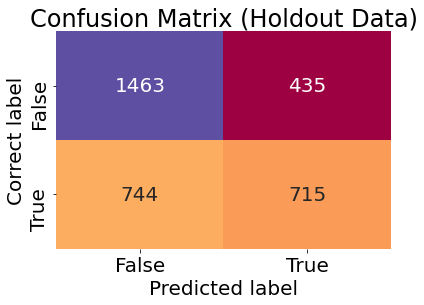

In [44]:
models.test_scores(model_name = "log_reg", 
                   verbose_results = False, 
                   all_metrics = False)

# Logistic Regression continues with unstable results even for n-gram 1,2
# for precision and recall

CV ROC_AUC SCORE: 0.68
CV PARAMS:  {'alpha': 1}

ROC AUC on test data: 0.69

Classification Report on test data:
               precision    recall  f1-score   support

           0       0.68      0.70      0.69      1898
           1       0.60      0.58      0.59      1459

    accuracy                           0.65      3357
   macro avg       0.64      0.64      0.64      3357
weighted avg       0.65      0.65      0.65      3357



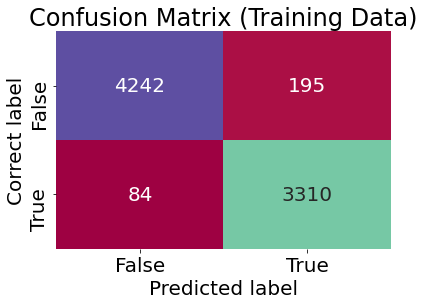

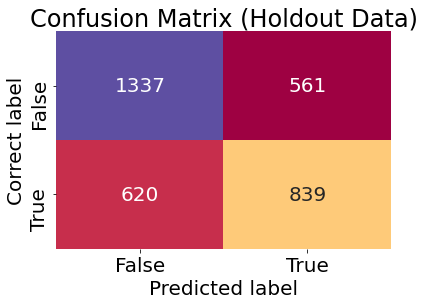

In [45]:
models.test_scores(model_name = "mnb", 
                   verbose_results = False, 
                   all_metrics = False)

# Again, Multinomial Naive Bayes appears more stable but divergence 
# between precision and recall for true and false statements is showing for n-gram 1,2

In [46]:
models = Binary_Classification(x = df.light_normalization, 
                               y = df[["veracity"]], 
                               scoring = "roc_auc", 
                               test_size = 0.3, 
                               n_folds = 3, 
                               standardize = False,
                               nlp = True,
                               vectorizer = CountVectorizer(lowercase = False, ngram_range = (1,3)))
                     
models.compare()

*** log_reg ***
CV ROC_AUC SCORE: 0.69
CV PARAMS:  {'C': 0.1}

*** mnb ***
CV ROC_AUC SCORE: 0.68
CV PARAMS:  {'alpha': 1}

*** ran_for ***
CV ROC_AUC SCORE: 0.64
CV PARAMS:  {'criterion': 'entropy', 'max_depth': 15, 'max_features': 'auto', 'n_estimators': 30}



CV ROC_AUC SCORE: 0.69
CV PARAMS:  {'C': 0.1}

ROC AUC on test data: 0.70

Classification Report on test data:
               precision    recall  f1-score   support

           0       0.66      0.79      0.72      1898
           1       0.63      0.48      0.55      1459

    accuracy                           0.65      3357
   macro avg       0.65      0.63      0.63      3357
weighted avg       0.65      0.65      0.64      3357



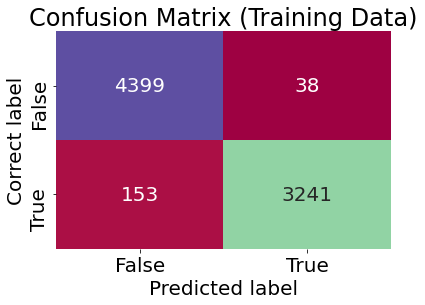

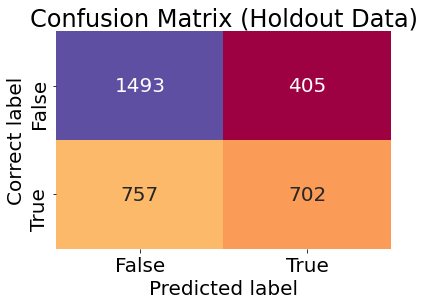

In [47]:
models.test_scores(model_name = "log_reg", 
                   verbose_results = False, 
                   all_metrics = False)

CV ROC_AUC SCORE: 0.68
CV PARAMS:  {'alpha': 1}

ROC AUC on test data: 0.69

Classification Report on test data:
               precision    recall  f1-score   support

           0       0.68      0.72      0.70      1898
           1       0.60      0.55      0.57      1459

    accuracy                           0.65      3357
   macro avg       0.64      0.64      0.64      3357
weighted avg       0.64      0.65      0.64      3357



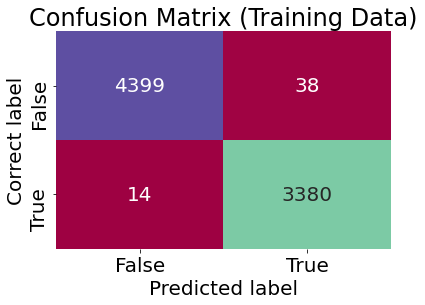

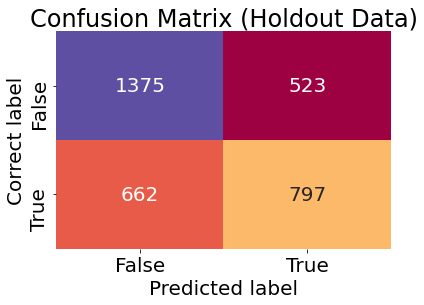

In [48]:
models.test_scores(model_name = "mnb", 
                   verbose_results = False, 
                   all_metrics = False)

# Logistic Regression is now trending towards stability while MNB is doing the opposite for n-gram 1,3 for precision and recall

# Full Normalization * N-gram Models (1-2 & 1-3) * 3 Classifiers

In [49]:
models = Binary_Classification(x = df.full_normalization, 
                               y = df[["veracity"]], 
                               scoring = "roc_auc", 
                               test_size = 0.3, 
                               n_folds = 3, 
                               standardize = False,
                               nlp = True,
                               vectorizer = CountVectorizer(lowercase = False, ngram_range = (1,2)))
                     
models.compare()

*** log_reg ***
CV ROC_AUC SCORE: 0.66
CV PARAMS:  {'C': 0.1}

*** mnb ***
CV ROC_AUC SCORE: 0.65
CV PARAMS:  {'alpha': 5}

*** ran_for ***
CV ROC_AUC SCORE: 0.63
CV PARAMS:  {'criterion': 'gini', 'max_depth': 15, 'max_features': 'auto', 'n_estimators': 30}



CV ROC_AUC SCORE: 0.66
CV PARAMS:  {'C': 0.1}

ROC AUC on test data: 0.68

Classification Report on test data:
               precision    recall  f1-score   support

           0       0.65      0.79      0.71      1898
           1       0.62      0.46      0.53      1459

    accuracy                           0.64      3357
   macro avg       0.64      0.62      0.62      3357
weighted avg       0.64      0.64      0.63      3357



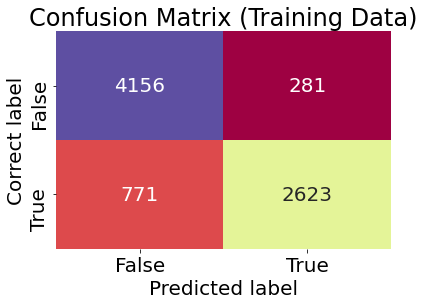

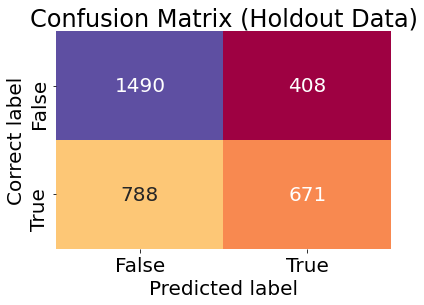

In [50]:
models.test_scores(model_name = "log_reg", 
                   verbose_results = False, 
                   all_metrics = False)

CV ROC_AUC SCORE: 0.65
CV PARAMS:  {'alpha': 5}

ROC AUC on test data: 0.67

Classification Report on test data:
               precision    recall  f1-score   support

           0       0.63      0.85      0.72      1898
           1       0.64      0.35      0.45      1459

    accuracy                           0.63      3357
   macro avg       0.63      0.60      0.58      3357
weighted avg       0.63      0.63      0.60      3357



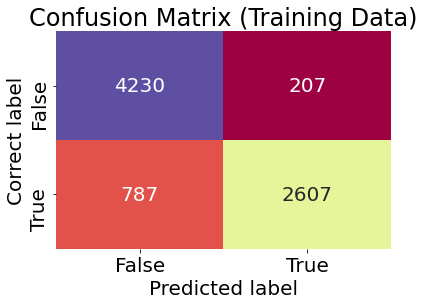

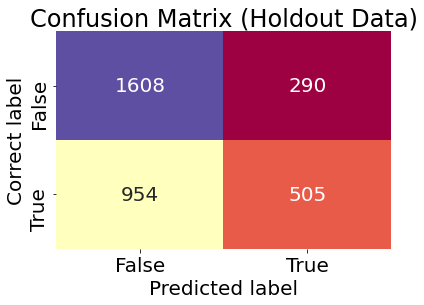

In [51]:
models.test_scores(model_name = "mnb", 
                   verbose_results = False, 
                   all_metrics = False)

In [52]:
models = Binary_Classification(x = df.full_normalization, 
                               y = df[["veracity"]], 
                               scoring = "roc_auc", 
                               test_size = 0.3, 
                               n_folds = 3, 
                               standardize = False,
                               nlp = True,
                               vectorizer = CountVectorizer(lowercase = False, ngram_range = (1,3)))
                     
models.compare()

*** log_reg ***
CV ROC_AUC SCORE: 0.67
CV PARAMS:  {'C': 0.1}

*** mnb ***
CV ROC_AUC SCORE: 0.65
CV PARAMS:  {'alpha': 5}

*** ran_for ***
CV ROC_AUC SCORE: 0.61
CV PARAMS:  {'criterion': 'gini', 'max_depth': 15, 'max_features': 'auto', 'n_estimators': 30}



CV ROC_AUC SCORE: 0.67
CV PARAMS:  {'C': 0.1}

ROC AUC on test data: 0.68

Classification Report on test data:
               precision    recall  f1-score   support

           0       0.66      0.79      0.72      1898
           1       0.63      0.46      0.53      1459

    accuracy                           0.65      3357
   macro avg       0.64      0.63      0.63      3357
weighted avg       0.65      0.65      0.64      3357



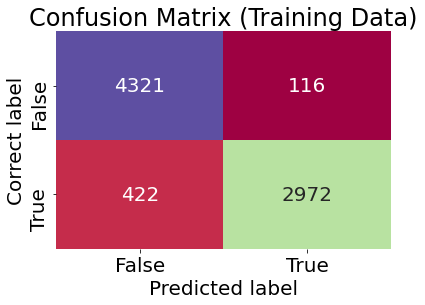

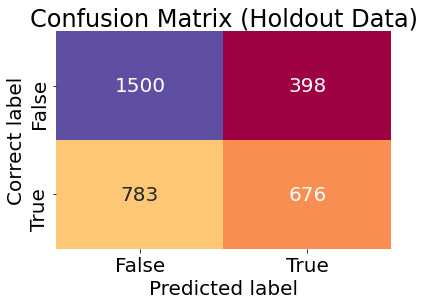

In [53]:
models.test_scores(model_name = "log_reg", 
                   verbose_results = False, 
                   all_metrics = False)

CV ROC_AUC SCORE: 0.65
CV PARAMS:  {'alpha': 5}

ROC AUC on test data: 0.67

Classification Report on test data:
               precision    recall  f1-score   support

           0       0.62      0.86      0.72      1898
           1       0.64      0.33      0.43      1459

    accuracy                           0.63      3357
   macro avg       0.63      0.59      0.58      3357
weighted avg       0.63      0.63      0.60      3357



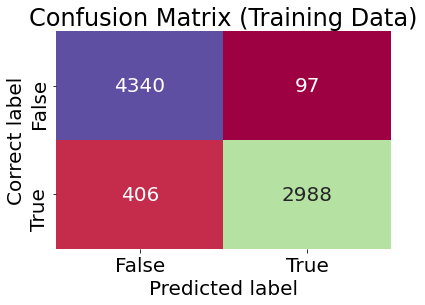

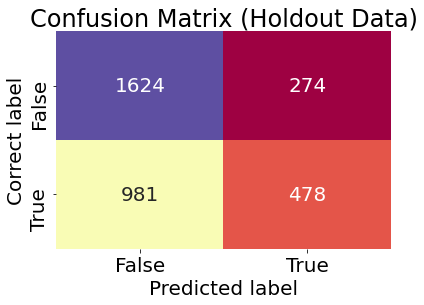

In [54]:
models.test_scores(model_name = "mnb", 
                   verbose_results = False, 
                   all_metrics = False)

# Summary
### again no model greatly outperformed any other; full normalization performs worse on training and test prediction for n-gram sizes 1-2 and 1-3

# Term Frequency-Inverse Document Frequency (tf-idf) model

Terms given score based on: 

(1) frequency in single text and 

(2) frequency in all texts

In [55]:
models = Binary_Classification(x = df.light_normalization, 
                               y = df[["veracity"]], 
                               scoring = "roc_auc", 
                               test_size = 0.3, 
                               n_folds = 3, 
                               standardize = False,
                               nlp = True,
                               vectorizer = TfidfVectorizer(lowercase = False, ngram_range = (1,2)))
                     
models.compare()

*** log_reg ***
CV ROC_AUC SCORE: 0.69
CV PARAMS:  {'C': 1}

*** mnb ***
CV ROC_AUC SCORE: 0.68
CV PARAMS:  {'alpha': 1}

*** ran_for ***
CV ROC_AUC SCORE: 0.64
CV PARAMS:  {'criterion': 'gini', 'max_depth': 15, 'max_features': 'auto', 'n_estimators': 30}



CV ROC_AUC SCORE: 0.69
CV PARAMS:  {'C': 1}

ROC AUC on test data: 0.70

Classification Report on test data:
               precision    recall  f1-score   support

           0       0.67      0.78      0.72      1898
           1       0.64      0.51      0.56      1459

    accuracy                           0.66      3357
   macro avg       0.66      0.64      0.64      3357
weighted avg       0.66      0.66      0.65      3357



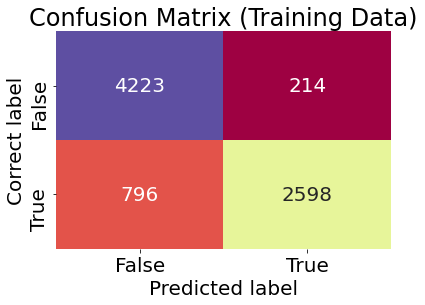

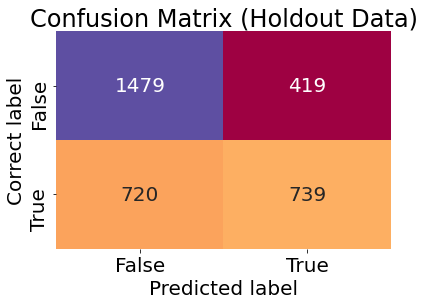

In [56]:
models.test_scores(model_name = "log_reg", 
                   verbose_results = False, 
                   all_metrics = False)

CV ROC_AUC SCORE: 0.68
CV PARAMS:  {'alpha': 1}

ROC AUC on test data: 0.69

Classification Report on test data:
               precision    recall  f1-score   support

           0       0.62      0.89      0.73      1898
           1       0.66      0.29      0.40      1459

    accuracy                           0.63      3357
   macro avg       0.64      0.59      0.57      3357
weighted avg       0.64      0.63      0.59      3357



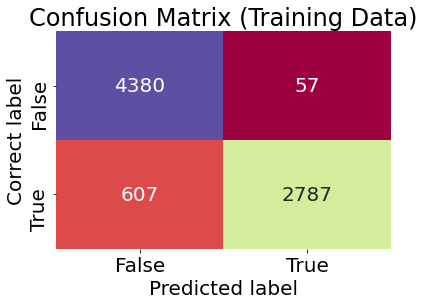

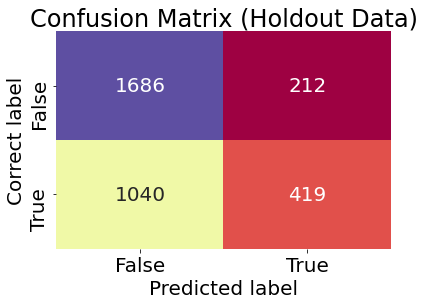

In [57]:
models.test_scores(model_name = "mnb", 
                   verbose_results = False, 
                   all_metrics = False)

In [58]:
models = Binary_Classification(x = df.light_normalization, 
                               y = df[["veracity"]], 
                               scoring = "roc_auc", 
                               test_size = 0.3, 
                               n_folds = 3, 
                               standardize = False,
                               nlp = True,
                               vectorizer = TfidfVectorizer(lowercase = False, ngram_range = (1,3)))
                     
models.compare()

*** log_reg ***
CV ROC_AUC SCORE: 0.69
CV PARAMS:  {'C': 1}

*** mnb ***
CV ROC_AUC SCORE: 0.68
CV PARAMS:  {'alpha': 1}

*** ran_for ***
CV ROC_AUC SCORE: 0.62
CV PARAMS:  {'criterion': 'gini', 'max_depth': 15, 'max_features': 'auto', 'n_estimators': 30}



CV ROC_AUC SCORE: 0.69
CV PARAMS:  {'C': 1}

ROC AUC on test data: 0.71

Classification Report on test data:
               precision    recall  f1-score   support

           0       0.67      0.76      0.71      1898
           1       0.63      0.52      0.57      1459

    accuracy                           0.66      3357
   macro avg       0.65      0.64      0.64      3357
weighted avg       0.65      0.66      0.65      3357



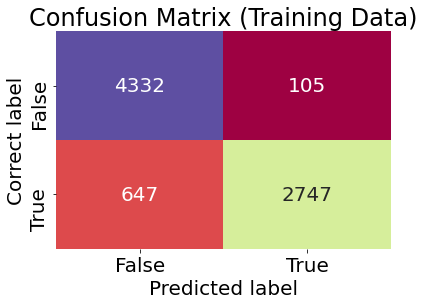

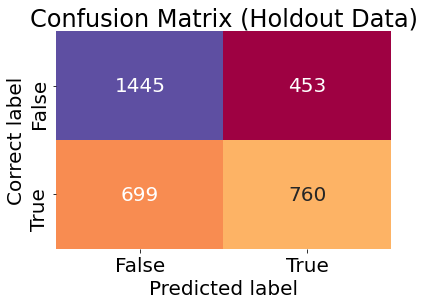

In [59]:
models.test_scores(model_name = "log_reg", 
                   verbose_results = False, 
                   all_metrics = False)

CV ROC_AUC SCORE: 0.68
CV PARAMS:  {'alpha': 1}

ROC AUC on test data: 0.69

Classification Report on test data:
               precision    recall  f1-score   support

           0       0.61      0.91      0.73      1898
           1       0.68      0.26      0.37      1459

    accuracy                           0.62      3357
   macro avg       0.65      0.58      0.55      3357
weighted avg       0.64      0.62      0.58      3357



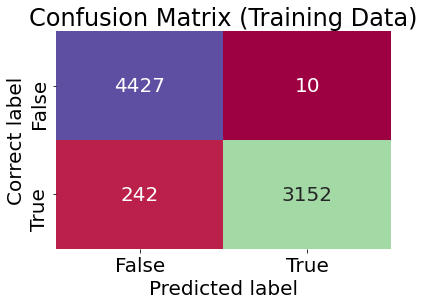

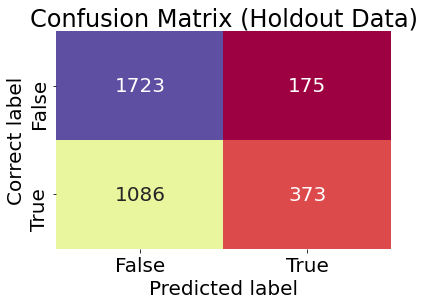

In [60]:
models.test_scores(model_name = "mnb", 
                   verbose_results = False, 
                   all_metrics = False)

# TF-IDF doesn't outperform simpler models

### What are the strongly predictive features?

We use a neat trick to identify strongly predictive features (i.e. words). 

* first, create a data set such that each row has exactly one feature. This is represented by the identity matrix.

        ex) features = "Trump", "people", "the"
* use the trained classifier to make predictions on this matrix

        ex) clf.pred(features)
* sort the rows by predicted probabilities, and pick the top and bottom $K$ rows

        ex) Trump & 89%, people & 10%, the & 1%

In [61]:
_ , itest = train_test_split(range(df.shape[0]), test_size=0.3, random_state = 0)
mask = np.zeros(df.shape[0], dtype=np.bool)
mask[itest] = True

In [62]:
def make_xy(df, features, target, vectorizer = None):
    X = vectorizer.fit_transform(df[features]) 
    y = (df[target] == True)
    return X, y

vectorizer = TfidfVectorizer(lowercase = False, ngram_range = (1,2))

X, y = make_xy(df, "light_normalization", "veracity", vectorizer)

xtrain = X[mask]
ytrain = y[mask]
xtest = X[~mask]
ytest = y[~mask]

model = MultinomialNB(1).fit(xtrain, ytrain)

training_accuracy = model.score(xtrain, ytrain)
test_accuracy = model.score(xtest, ytest)

print("Accuracy on training data: ", "{:.2f}".format(training_accuracy))
print("Accuracy on test data:     ", "{:.2f}".format(test_accuracy))

Accuracy on training data:  0.93
Accuracy on test data:      0.61


In [ ]:
## End of Notebook